# Fall Alamo Float Comparisons (2016-2017)

In [1]:
%matplotlib inline

import datetime

import pandas as pd
from netCDF4 import Dataset

import urllib

import cmocean

/Users/bell/anaconda/envs/jupyter/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
### using code from https://ioos.github.io/notebooks_demos/notebooks/2017-03-21-ERDDAP_IOOS_Sensor_Map/
import requests
try:
    from urllib.parse import urlencode
except ImportError:
    from urllib import urlencode


def encode_erddap(urlbase, fname, columns, params):
    """
    urlbase: the base string for the endpoint
             (e.g.: https://erddap.axiomdatascience.com/erddap/tabledap).
    fname: the data source (e.g.: `sensor_service`) and the response (e.g.: `.csvp` for CSV).
    columns: the columns of the return table.
    params: the parameters for the query.

    Returns a valid ERDDAP endpoint.
    """
    urlbase = urlbase.rstrip('/')
    if not urlbase.lower().startswith(('http:', 'https:')):
        msg = 'Expected valid URL but got {}'.format
        raise ValueError(msg(urlbase))

    columns = ','.join(columns)
    params = urlencode(params)
    endpoint = '{urlbase}/{fname}?{columns}&{params}'.format

    url = endpoint(urlbase=urlbase, fname=fname,
                   columns=columns, params=params)
    r = requests.get(url)
    r.raise_for_status()
    return url

## Set parameters    

In [23]:
try:
    from urllib.parse import unquote
except ImportError:
    from urllib2 import unquote

# return profile for float id
def get_profile(saildrone_id,starttime,endtime):
    
    urlbase = 'http://dunkel.pmel.noaa.gov:9290/erddap/tabledap/'

    fname = 'saildrone_data_2017.csvp'

    columns = ('trajectory',
               'longitude',
               'latitude',
               'time',
               'TEMP_CTD_MEAN',
               'TEMP_IR_MEAN',
               'CHLOR_MEAN',
               'CHLOR_STDDEV')
    params = {
        # Inequalities do not exist in HTTP parameters,
        # so we need to hardcode the `>` in the time key to get a '>='.
        # Note that a '>' or '<' cannot be encoded with `urlencode`, only `>=` and `<=`.
        'time>': starttime+'T00:00:00Z',
        'time<': endtime+'T00:00:00Z'
    }

    url = encode_erddap(urlbase, fname, columns, params)

    df = pd.read_csv(url, index_col=0, parse_dates=['time (UTC)'])
    
    return df

In [25]:
sd1 = get_profile(1001,'2017-07-01','2017-12-01')

In [26]:
sd1.keys()

Index([u'longitude (degrees_east)', u'latitude (degrees_north)', u'time (UTC)',
       u'TEMP_CTD_MEAN (degrees_c)', u'TEMP_IR_MEAN (degrees_c)',
       u'CHLOR_MEAN (microgram L-1)', u'CHLOR_STDDEV (microgram L-1)'],
      dtype='object')

### Map via Cartopy

In [6]:
#using Cartopy for mapping
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def erddap_etopo1():
    """get subset of etopo1 data from erddap"""
    
    urllib.urlretrieve("http://coastwatch.pfeg.noaa.gov/erddap/griddap/etopo180.nc?altitude[(50):1:(90.0)][(-180.0):1:(-130)]","data/etopo1_tmp.nc")
    
def etopo1_subset(file='etopo1.nc', region=None):
    """ read in ardemV2 topography/bathymetry. """
    
    bathydata = Dataset(file)
    
    topoin = bathydata.variables['altitude'][:]
    lons = bathydata.variables['longitude'][:]
    lats = bathydata.variables['latitude'][:]
    bathydata.close()
    
    return(topoin, lats, lons)

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(13, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')


In [ ]:
### Region Wide
extent = [--176, -158, 54, 72]
erddap_etopo1()
(topoin, lats, lons) = etopo1_subset(file='data/etopo1_tmp.nc')

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

## Scatter plot of integrated temp
ax.scatter([sd1['longitude (degrees_east)']],[sd1['latitude (degrees_north)']],
        15, c=[sd1['TEMP_CTD_MEAN (degrees_c)']], linewidth=0, edgecolors='none', marker='o', vmin=-2, vmax=15,
        cmap=cmocean.cm.thermal, transform=transformation, zorder=3
        )

## bathymetry contours
CS = plt.contour(lons, lats, topoin, [-1000, -100, -50, -25,], 
                 colors='k', alpha=0.4, linestyle='--', linewidths=1, zorder=2,
                 transform=transformation)
CS = plt.contourf(lons, lats, topoin, [-1000, -100, -50, -25,], 
                 colors=('#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0'), extend='both', zorder=1,
                 transform=transformation)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

/Users/bell/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)
No handlers could be found for logger "shapely.geos"


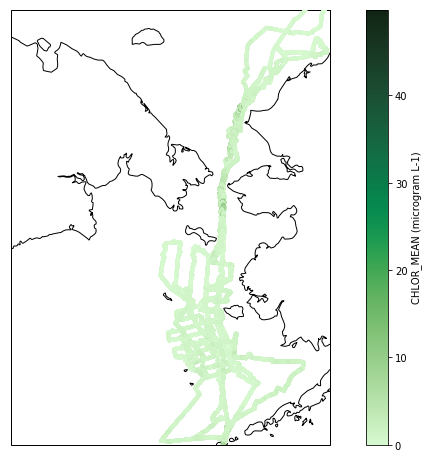

In [22]:
### Region Wide no bathymetry
extent = [--176, -158, 54, 72]

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

## Scatter plot of integrated temp
axs = ax.scatter([sd1['longitude (degrees_east)']],[sd1['latitude (degrees_north)']], 15,
                 c=[sd1['CHLOR_MEAN (microgram L-1)']], 
                 linewidth=0, edgecolors='none', marker='o', 
                 vmin=0, vmax=sd1['CHLOR_MEAN (microgram L-1)'].max(),
                 cmap=cmocean.cm.algae, transform=transformation, zorder=3
                 )
cb = plt.colorbar(axs)
cb.set_label('CHLOR_MEAN (microgram L-1)')
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)


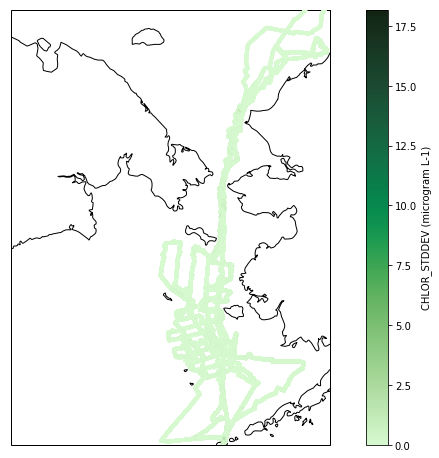

In [28]:
### Region Wide no bathymetry
extent = [--176, -158, 54, 72]

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

## Scatter plot of integrated temp
axs = ax.scatter([sd1['longitude (degrees_east)']],[sd1['latitude (degrees_north)']], 15,
                 c=[sd1['CHLOR_STDDEV (microgram L-1)']], 
                 linewidth=0, edgecolors='none', marker='o', 
                 vmin=0, vmax=sd1['CHLOR_STDDEV (microgram L-1)'].max(),
                 cmap=cmocean.cm.algae, transform=transformation, zorder=3
                 )
cb = plt.colorbar(axs)
cb.set_label('CHLOR_STDDEV (microgram L-1)')
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)